In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2 as cv
from galaxy2galaxy import problems
from skimage.measure import label
import tensorflow as tf
import plot_utils

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
tf.executing_eagerly()

True

In [3]:
sigma_noise = 23.59

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # Add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb
    
    sigma_cfht = sigma_noise
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma_cfht, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise
    dico['targets'] /= 4000
    dico['inputs'] /= 4000

    return dico['inputs'], dico['targets'], dico['psf_cfht']/dico['psf_hst']

In [4]:
# Utility Functions

def fftconvolve(image, kernel):
   
    x = tf.signal.fftshift(tf.signal.fft2d(tf.cast(image, tf.complex64)))
    y = tf.signal.fftshift(tf.signal.fft2d(tf.cast(kernel, tf.complex64)))
    result = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(x * y))))

    return tf.cast(result, tf.float32)


def fft(data):

    return tf.math.real( tf.convert_to_tensor(1.0/data.get_shape().as_list()[0], tf.complex64) * 
                         tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(tf.cast(data, tf.complex64)))) )


def ifft(data):

    return tf.math.real( tf.convert_to_tensor(data.get_shape().as_list()[0], tf.complex64) *
                         tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(tf.cast(data, tf.complex64)))) )


def nmse(signal_1, signal_2):

    return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)


def soft_thresh(data, threshold):
    
    return tf.cast(tf.math.sign(data) * (data - threshold) * tf.cast(data >= threshold, tf.float32), tf.float32)


def blob_mask(img,background=0,connectivity=2):
    
    """This function keeps the biggest blob in the image
    
    INPUT: img, Numpy Array
           background, integer
           connectivity, integer
    OUTPUT: mask, boolean Numpy Array"""
    
    labels = label(img,background=background,connectivity=connectivity)
    
    # find the biggest blob
    indices = np.unique(labels)
    sizes = np.zeros(indices.shape)
    for i in indices[1:]:
        sizes[i] = (labels==i).sum()
    main_blob_label = np.argmax(sizes)
    main_blob_estimate = (labels==main_blob_label)*main_blob_label
    
    # extract mask
    mask = (labels-main_blob_estimate)==0
    return mask

### Loading Galaxy Images

In [5]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the hsc_problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('attrs2img_cosmos_parametric_cfht2hst')
    dset = problem128.dataset(Modes.EVAL, data_dir='/local/home/ua264756/Data/attrs2img_cosmos_parametric_cfht2hst')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 128
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /local/home/ua264756/Data/attrs2img_cosmos_parametric_cfht2hst/attrs2img_cosmos_parametric_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


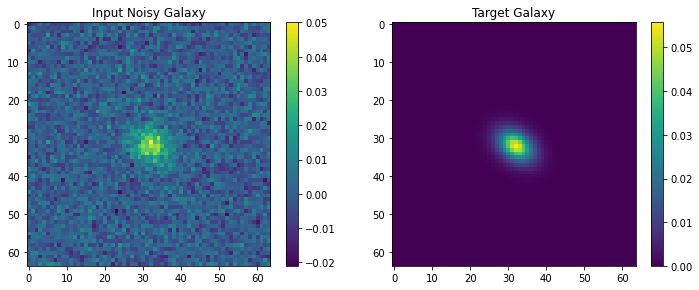

24.1561122238636


In [6]:
ind_val = 4  # Corresponding ground truth & PSF in a batch

gal_input = np.squeeze(batch[0][ind_val])
gal_target = np.squeeze(batch[1][ind_val])

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(gal_input)
plt.title("Input Noisy Galaxy")
plt.colorbar(shrink=0.375)

plt.subplot(122)
plt.imshow(gal_target)
plt.title("Target Galaxy")
plt.colorbar(shrink=0.375)

plt.show()

sigma_est = np.std(gal_input[0:20, 0:20])
print(sigma_est*4000)

### Loading PSF

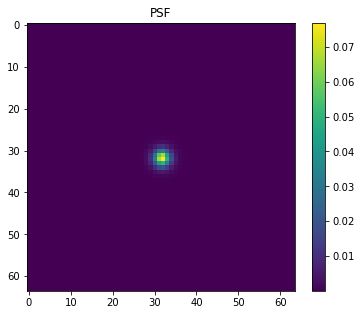

1.0


In [7]:
psf = cv.resize(np.real(np.fft.ifftshift(np.fft.irfft2(np.squeeze(batch[2][ind_val])))), (64,64), interpolation = cv.INTER_AREA)
psf /= np.sum(psf)

plt.figure(figsize=(6,6))
plt.imshow(psf)
plt.title('PSF')
plt.colorbar(shrink=0.82)
plt.show()

print(np.sum(psf))

### Load Trained U-Net Model

In [8]:
model_1 = tf.keras.models.load_model('UNet_Denoiser/Models/UNet_param_ep{10}spe{6250}nb{32}', compile=False)

# ADMM in TensorFlow

In [9]:
gal_input_tf = tf.cast(gal_input, tf.float32)
psf_tf = tf.cast(psf, tf.float32) 

gal_target_tf = tf.cast(gal_target, tf.float32)
gal_target_nmse = tf.cast((gal_target > 2*(sigma_noise/4000)) * gal_target, tf.float32)

In [10]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)

 
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, var):

    temp = z - x_rec
    shape = mu.get_shape().as_list()
    
    cost_val = ( tf.cast(0.5, tf.float32) * rho * tf.norm(temp)**2  -
                 tf.matmul(tf.reshape(mu, [1, shape[0]*shape[1]]), tf.reshape(temp, [shape[0]*shape[1], 1]))  +
                 (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2 )
     
    return tf.keras.backend.eval(cost_val).flatten()


# Spectral value
def max_sv(psf, sigma, rho):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H  +  tf.cast(rho*sigma**2, tf.complex64))
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(rho, sv, sigma):

    return (tf.cast(1.0, tf.float32) / 
            ((sv/(sigma**2) + rho) * tf.cast(1.0 + 1.0e-5, tf.float32)))


# Run ADMM
def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, disp_step, n_iter, model):
    
    
    # Convert arrays to tensors
    
    x_0 = tf.cast(x_0, tf.float32)
    z_0 = tf.cast(z_0, tf.float32)
    mu_0 = tf.cast(mu_0, tf.float32)
    rho_0 = tf.cast(rho_0, tf.float32)          # Augmented lagrangian hyperparameter
    rho_max = tf.cast(rho_max, tf.float32)      # max rho value
    eta = tf.cast(eta, tf.float32)              # should be between - [0, 1)
    gamma = tf.cast(gamma, tf.float32)          # multiplicative rho factor -- Should be > 1
    
    
    # declare variables
    
    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = tf.zeros(tf.shape(y.shape), tf.float32)
    count = 0
    
    
    # ADMM parameters
    
    x_k = x_0
    z_k = z_0
    mu_k = mu_0
    rho_k = rho_0                                  # Augmented lagrangian hyperparameter
    delta_k = tf.cast(0.0, tf.float32)      
 

    # FISTA parameters
    
    t_k = tf.cast(1.0, tf.float32)
    z_fista_old = z_0
    sigma = tf.cast(sigma_noise, tf.float32) / 4000.0
    
    
    # square of spectral radius of convolution matrix
    
    sv = max_sv(psf, sigma, rho_k)         
    

    # The gradient descent step
    
    alpha = get_alpha(rho_k, sv, sigma) 
    
    
    # ADMM Loop 
    
    for k in range(n_iter):
        
        
        ## FISTA update
        
        x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf)  + 
                                      mu_k * sigma**2  + 
                                      rho_k * sigma**2 * (z_fista_old - z_k)) 
        
        x_k1 = proj(x_k1)             # Project negative values
        
        t_k1 = ( (tf.cast(1.0, tf.float32) + tf.math.sqrt(tf.cast(4.0, tf.float32)*t_k**2 + tf.cast(1.0, tf.float32))) 
                / tf.cast(2.0, tf.float32) )
        
        lambda_fista = tf.cast(1.0, tf.float32) + (t_k -  tf.cast(1.0, tf.float32)) / t_k1
        
        z_fista_new = x_k + lambda_fista * (x_k1 - x_k)
        
        z_fista_old = z_fista_new
        t_k = t_k1
        
           
    
        ## Denoising sub-step
     
        z_k1 = x_k1 + (mu_k / rho_k)

        # U-Net Denoising
    
        z_k1 = tf.expand_dims(tf.expand_dims(z_k1, axis=0), axis=-1)
        z_k1 = tf.cast(tf.squeeze(model(z_k1)), tf.float32)
        

        ## mu update
        
        mu_k1 = mu_k + (x_k1 - z_k1) * rho_k
    
    
        
        ## Cost
        
        cost.append(cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2))
        
        
        
        ## Rho & alpha update       

        test1 = (tf.math.abs(gamma * rho_k) < tf.math.abs(rho_max))

        delta_k1 = tf.cond(test1, lambda: (tf.cast(1.0/gal_input_tf.get_shape().as_list()[0], tf.float32) * 
                                           (tf.norm(x_k1 - x_k) + tf.norm(z_k1 - z_k) + tf.norm(mu_k1 - mu_k))), 
                                  lambda: delta_k)
                
        test2 = (test1 and (tf.math.abs(delta_k1) > tf.math.abs(eta * delta_k)))
        
        rho_k1 = tf.cond(test2, lambda: gamma * rho_k, lambda: rho_k)
        alpha = tf.cond(test2, lambda: get_alpha(rho_k1, sv, 1.0), lambda: alpha)

        
        
        
        # Update all variables
        
        delta_k = tf.cond(test1, lambda: delta_k1, lambda: delta_k)
        rho_k = rho_k1
        x_k = x_k1
        mu_k = mu_k1
        z_k = z_k1
        sv = max_sv(psf, sigma, rho_k)
        
      
        # Reconstruction
        
        final_im = x_k   
        
               
        # Compute NMSE
        
        nmse_arr[k] = nmse(gal_target_nmse, final_im)
        
        
        # Check if optimal reconstruction is achieved
        
        if nmse_arr[k]==np.min(nmse_arr):
            x_opt = final_im
        
        
        # Display plots
        
        if (k+1)%disp_step==0 and k!=0:
            
            #plot_utils.plot_iter(final_im, gal_target, y, k+1)
            
            fig = plt.subplots(1,3, figsize=(25,25))
            
            plt.subplot(131)
            plt.title('Reconstruction after {} iterations'.format(k+1))
            ax1 = plt.gca()
            rec = tf.keras.backend.get_value(final_im)
            im1 = ax1.imshow(rec)
            divider = make_axes_locatable(ax1)
            cax1 = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im1, cax=cax1)

            plt.subplot(132)
            plt.title('Target')
            ax2 = plt.gca()
            im2 = ax2.imshow(rec, cmap='gist_stern')
            divider = make_axes_locatable(ax2)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im2, cax=cax2)

            plt.subplot(133)
            plt.title('Intensity Plot (Central Slice)')
            ax3 = plt.gca()
            ax3.plot(tf.keras.backend.get_value(final_im)[y.get_shape().as_list()[0]//2,:], label='rec_im')           
            ax3.plot(gal_target[y.get_shape().as_list()[0]//2,:], label='target')  
            plt.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio())

            plt.show(fig)
          
        
    return x_opt, cost, nmse_arr

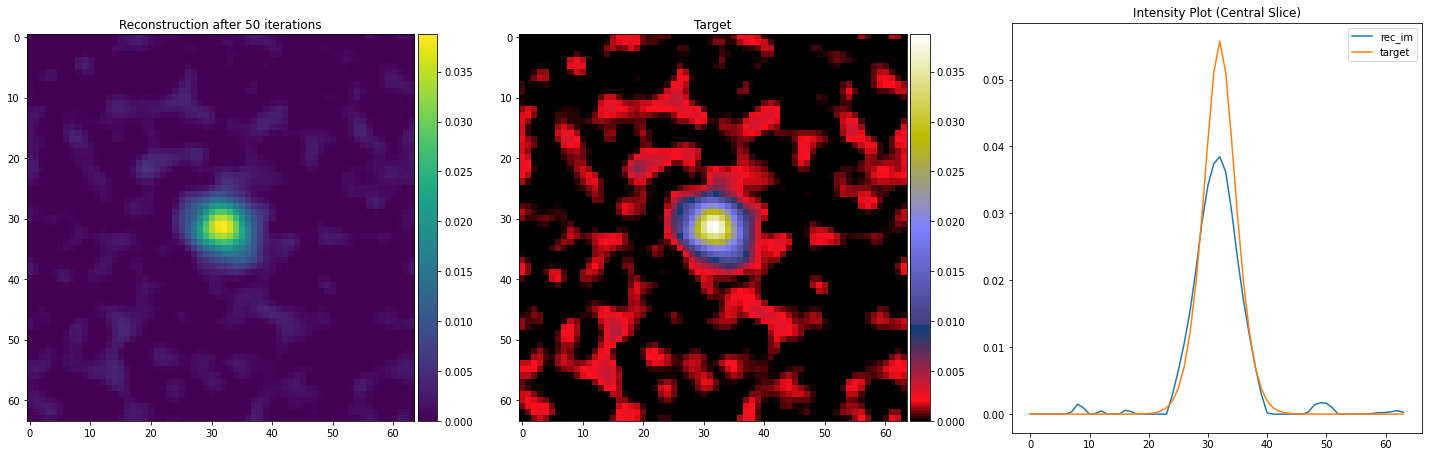

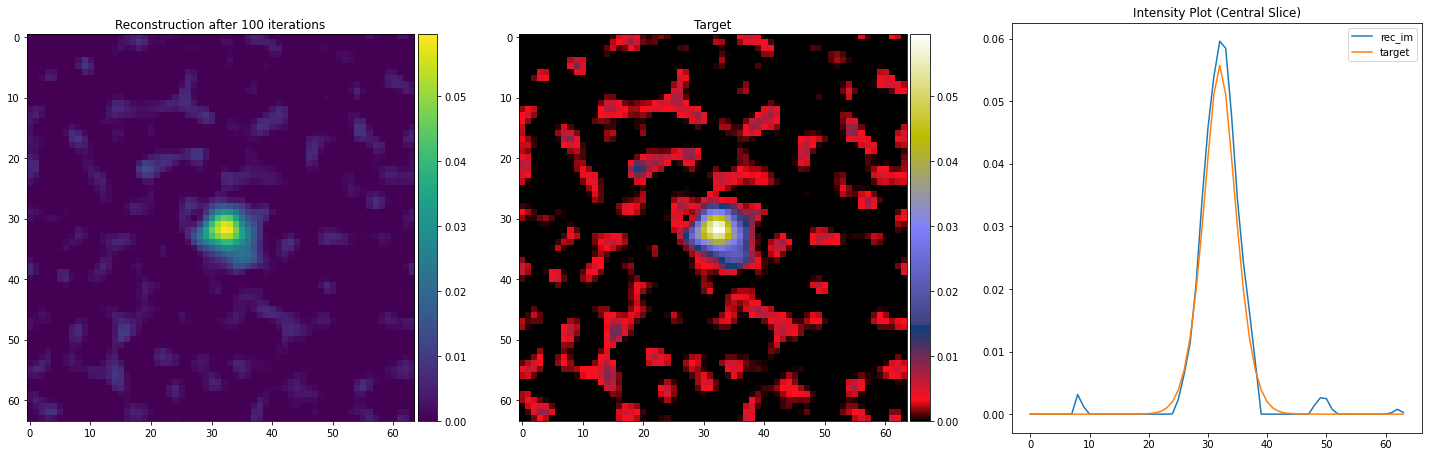

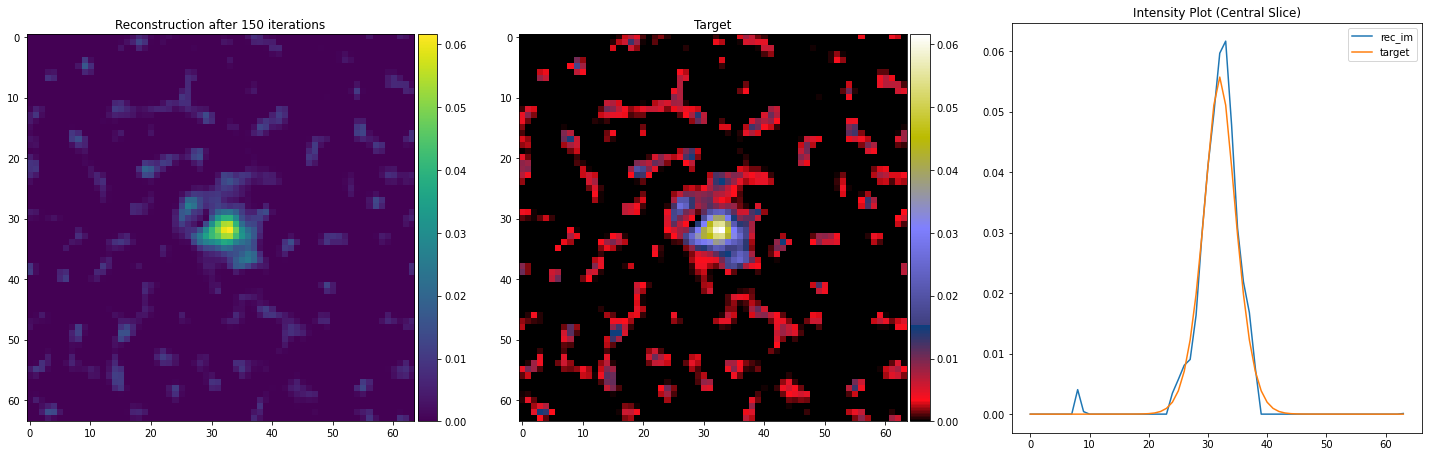

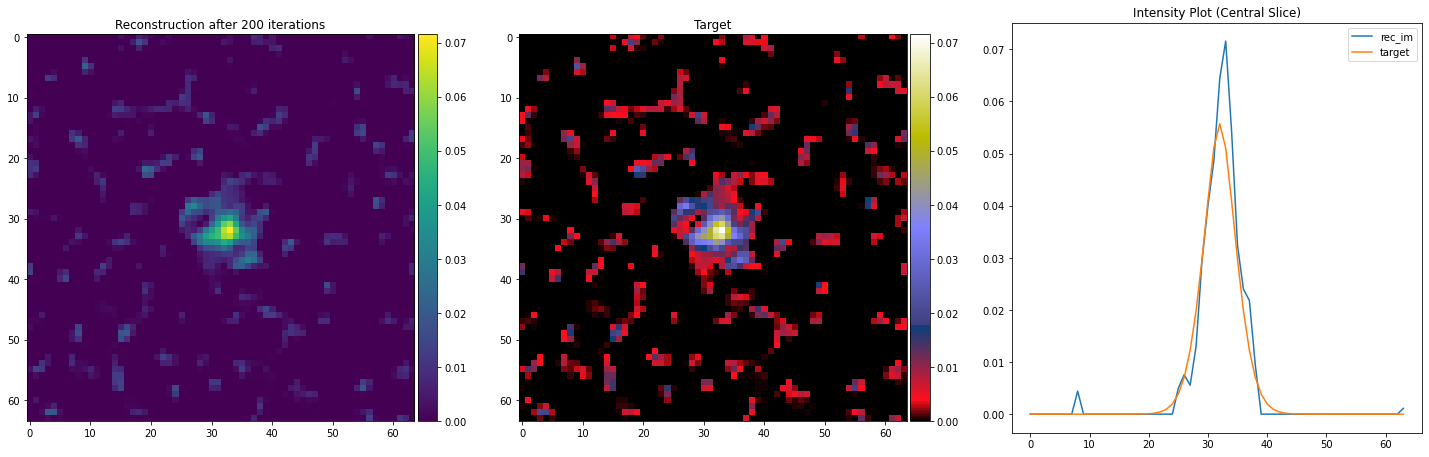

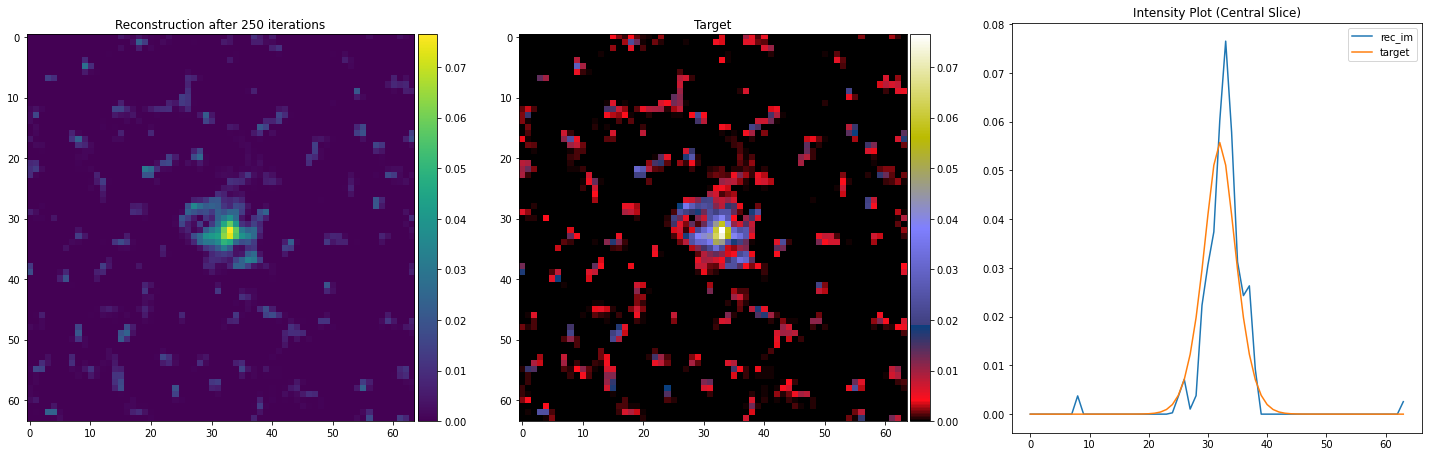

In [11]:
n_iter = 250
disp_step = 50


# ADMM parameters (initial)
x_0 = np.zeros(gal_input.shape)
z_0 = np.zeros(gal_input.shape)
mu_0 = 0.0                              
rho_0 = 50.0                         # Augmented lagrangian hyperparameter
rho_max = 200.0                      # max rho value
eta = 0.5                            # should be between - [0, 1)
gamma = 1.4                          # multiplicative rho factor -- Should be > 1


# Deconvolve the image
x_opt, cost, nmse_arr = runADMM(gal_input_tf, x_0, psf_tf, grad, z_0, mu_0, rho_0, 
                                rho_max, eta, gamma, disp_step, n_iter, model_1)

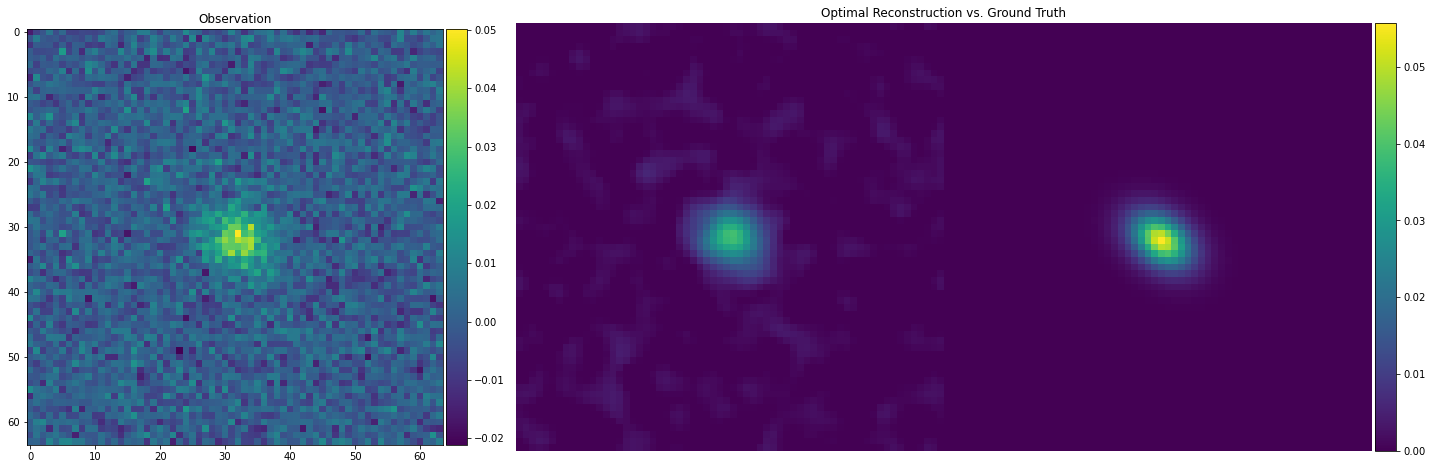

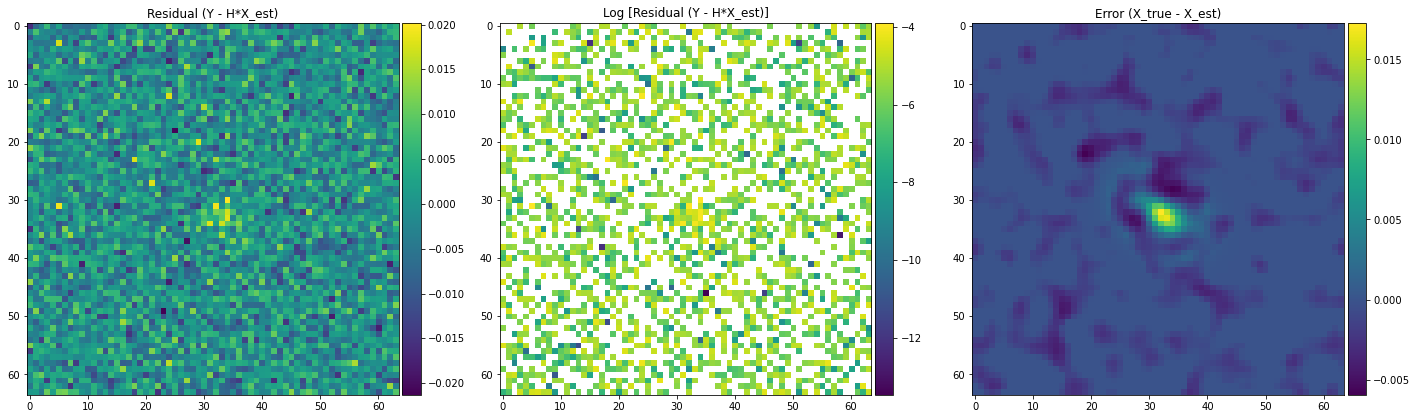

In [12]:
# Comparison
plot_utils.comparison(x_opt, gal_target_tf, gal_input_tf, psf_tf, fftconvolve)

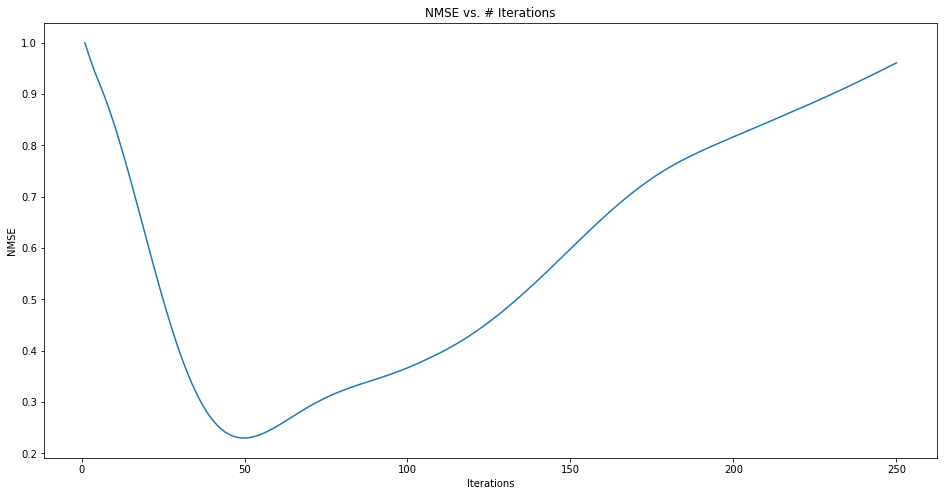


Minimum NMSE = 0.23010919988155365 (at [50] iterations)


In [13]:
# Plot NMSE
plot_utils.nmse(nmse_arr, n_iter)

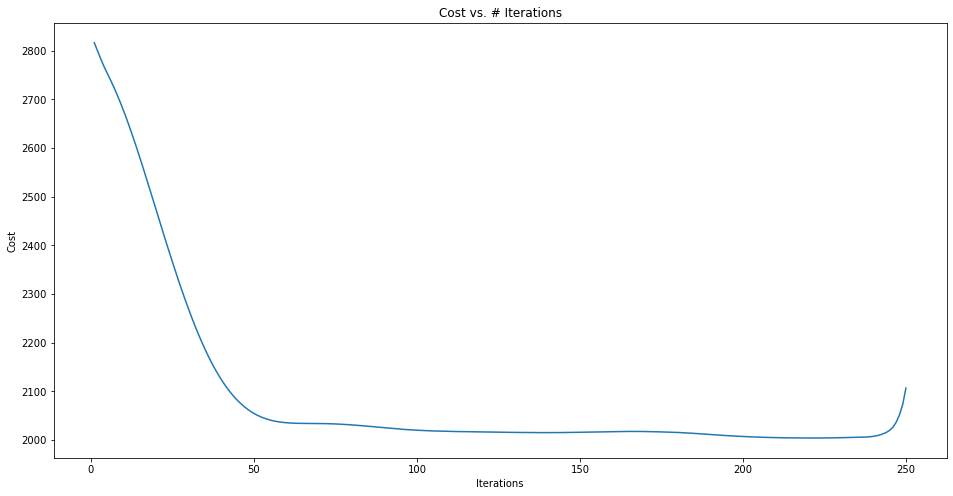


Minimum Cost = 2004.2353515625 (at [222] iterations)


In [14]:
# Plot Cost
plot_utils.cost(cost, n_iter)